<a href="https://colab.research.google.com/github/bimarshak7/GAN-image-restore/blob/main/ImageRestoration_Model_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook can be used to try the image restoration model with your images**  
 By default, it downloads image from https://thispersondoesnotexist.com, applies noise filter to produce noisy old image effect and tries to restore.

In [2]:
import gdown
import os
import cv2
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [4]:
url = "https://drive.google.com/uc?id=1HYb8QV94d2x5dTIGOHQet7Xod6F--foP"
gdown.download(url, quiet=True)

'filters.zip'

In [9]:
!unzip -q filters.zip
!rm -r filters/results

replace filters/0w63yoh9.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [29]:
def overlay_filter(original_image_path, filter_image_path, output_path,save=False,disp=True):
    # Load the original image
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Load the filter image and convert it to grayscale
    filter_image = cv2.imread(filter_image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the filter image to match the original image dimensions
    filter_image = cv2.resize(filter_image, (original_image.shape[1], original_image.shape[0]))
    # Randomly flip the filter image horizontally
    if random.random() < 0.5:
        filter_image = cv2.flip(filter_image, 1)

    # Randomly rotate the filter image by a random angle between -30 and 30 degrees
    angle = random.uniform(-90, 89)
    rows, cols = filter_image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    filter_image = cv2.warpAffine(filter_image, rotation_matrix, (cols, rows),borderMode=cv2.BORDER_REFLECT, borderValue=(255, 255, 255))
    # Switch blacks and whites in the filter image
    filter_image = 255 - filter_image

    # Create a 3-channel version of the filter image
    filter_image_rgb = cv2.merge((filter_image, filter_image, filter_image))

    beta = np.random.uniform(1,1.5)
    gamma = np.random.uniform(0.3,1)

    overlay = cv2.addWeighted(original_image, 1, filter_image_rgb, beta, gamma)

    if save:
      im_file = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
      dest =  output_path + original_image_path.split("/")[-1]
      cv2.imwrite(dest, im_file)
    if disp:
      fig, ax = plt.subplots(1, 2, figsize=(10,5))
      ax[0].imshow(original_image)
      ax[0].set_title("Original Image")
      ax[0].axis("off")
      ax[1].set_title("Noise Image")
      ax[1].imshow(overlay)
      ax[1].axis("off")
      plt.show()

In [30]:
import torch
from torch import nn
from torchvision.io import read_image
from torchvision import transforms
import torch.nn.functional as F

from matplotlib import pyplot as plt
from PIL import Image

In [31]:
class DownSampleConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):
        """
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

In [32]:
class UpSampleConv(nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel=4,
        strides=2,
        padding=1,
        activation=True,
        batchnorm=True,
        dropout=False
    ):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x

In [33]:
class Generator(nn.Module):

    def __init__(self, in_channels, out_channels):
        """
        Paper details:
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()

        # encoder/donwsample convs
        self.encoders = [
            DownSampleConv(in_channels, 64, batchnorm=False),  # bs x 64 x 128 x 128
            DownSampleConv(64, 128),  # bs x 128 x 64 x 64
            DownSampleConv(128, 256),  # bs x 256 x 32 x 32
            DownSampleConv(256, 512),  # bs x 512 x 16 x 16
            DownSampleConv(512, 512),  # bs x 512 x 8 x 8
            DownSampleConv(512, 512),  # bs x 512 x 4 x 4
            DownSampleConv(512, 512),  # bs x 512 x 2 x 2
            DownSampleConv(512, 512, batchnorm=False),  # bs x 512 x 1 x 1
        ]

        # decoder/upsample convs
        self.decoders = [
            UpSampleConv(512, 512, dropout=True),  # bs x 512 x 2 x 2
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 4 x 4
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 8 x 8
            UpSampleConv(1024, 512),  # bs x 512 x 16 x 16
            UpSampleConv(1024, 256),  # bs x 256 x 32 x 32
            UpSampleConv(512, 128),  # bs x 128 x 64 x 64
            UpSampleConv(256, 64),  # bs x 64 x 128 x 128
        ]
        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]
        self.final_conv = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Sigmoid()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            # print(x.shape, skip.shape)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        # print(x.shape)
        x = self.final_conv(x)
        return self.tanh(x)

In [34]:
url = "https://drive.google.com/uc?id=15iGUcz-wTwQvAHnLDJVZ2FYWfr5c3JsK"
gdown.download(url, "model.pth",quiet=True)

'model.pth'

In [35]:
gen = Generator(3,3)

In [36]:
gen.load_state_dict(torch.load("model.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

In [37]:
gen = gen.eval()

In [38]:
from torchvision.transforms import functional as F2
def pred(img,transform,trained=False):
  dog = read_image(img)


  dog_noise = transform(dog)

  dog_n = dog_noise.cuda() if trained else dog_noise
  dog_n = dog_n.unsqueeze(0)

  clear = gen(dog_n)
  show = clear.cpu().squeeze()

  disp = F2.to_pil_image(clear.squeeze())

  plt.figure(figsize=(10,5))

  plt.subplot(1,2,1)
  plt.imshow(transforms.Resize((256,256),antialias=True)(dog).permute(1,2,0))
  plt.title("Input Image")
  plt.axis("off")


  plt.subplot(1,2,2)
  plt.imshow(disp)
  plt.title("Output Image")
  plt.axis("off")

In [39]:
transform = transforms.Compose([
   transforms.ToPILImage(),
    transforms.Resize((256,256),antialias=True),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.45, 0.43, 0.40], std=[0.24, 0.24, 0.24]),
])

In [40]:
filters = sorted(os.listdir("/content/filters"))

In [41]:
def newTry():
  !wget https://thispersondoesnotexist.com/ -O o1.jpg -q
  filter = random.choice(filters)
  filter_path = os.path.join("filters",filter)
  overlay_filter("/content/o1.jpg", filter_path, "op",save=True,disp=False)
  pred("opo1.jpg",transform)

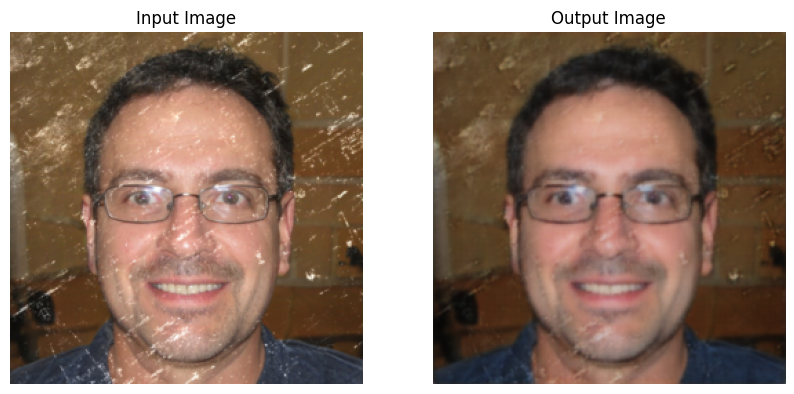

In [54]:
# rerun this cell to experiment with new image each time
newTry()